# Helper functions

In [1]:
import numpy as np
from scipy.constants import h, c, k
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from colour_system import *
cs = cs_hdtv

def planck(lam, T):
    """ Returns the spectral radiance of a black body at temperature T.

    Returns the spectral radiance, B(lam, T), in W.sr-1.m-2 of a black body
    at temperature T (in K) at a wavelength lam (in nm), using Planck's law.

    """

    lam_m = lam / 1.e9
    fac = h*c/lam_m/k/T
    B = 2*h*c**2/lam_m**5 / (np.exp(fac) - 1)
    return B

def normalize_spectrum(file_path):
    
    #load in spectrum data from txt
    spec = np.genfromtxt(file_path)
    
    #truncate to visible range
    spec_trunc = spec[np.logical_and(spec[:,0]>=380,spec[:,0]<=780)]
    
    #normalize the spectrum with respect to area
    area = np.sum(spec_trunc[:,1][:-1]*np.diff(spec_trunc[:,0][:]))
    
    return spec_trunc[:,0],spec_trunc[:,1]/area

def rebin_spectrum(axis, spec, bins, bkg=None):
    
    #sort spectrum into cmf bins
    ind = np.digitize(axis,bins)
    
    mean_spec = np.zeros(len(bins))
    
    #if background is provided, subtract background
    if bkg:
        for i in range(1,len(bins)):
            cond = np.where(ind==i)
            mean_spec[i-1] = np.nanmean(spec[cond]-bkg[cond])
    
    #otherwise, just take the mean in each bin
    else:
        for i in range(1,len(bins)):
            cond = np.where(ind==i)
            mean_spec[i-1] = np.nanmean(spec[cond])
    
    return mean_spec

lam = np.arange(380., 781., 5)

# Atmospheric params

In [68]:
#Rayleigh scattering parameter, a
a = [0.005, 0.018, 0.053, 0.130, 0.190, 0.200]

#Ozone density
NO3 = [1e19, 14e19, 16e19, 18e19, 30e19, 34e19]

#Ozone absorption cross-section
o3_data = np.genfromtxt("./spectra/O3_cross_section_cut.dat")

sigma_o3 = rebin_spectrum(o3_data[:,0],o3_data[:,1],lam)

# Blackbody spectrum

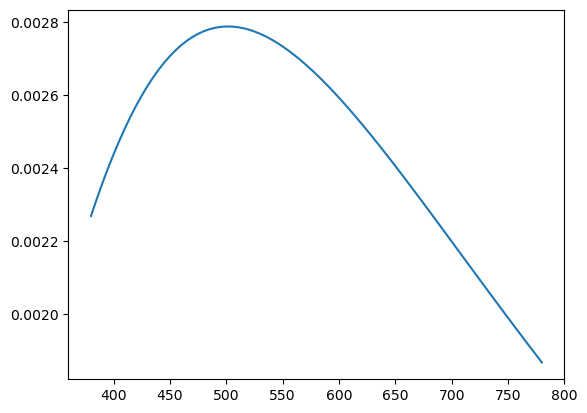

In [83]:
#Input stellar surface temperature
T = 5778

blackbody = planck(lam, T)

blackbody_area = np.sum(blackbody*5)

blackbody_norm = blackbody/blackbody_area

plt.plot(lam,blackbody_norm)

# Transformed spectrum

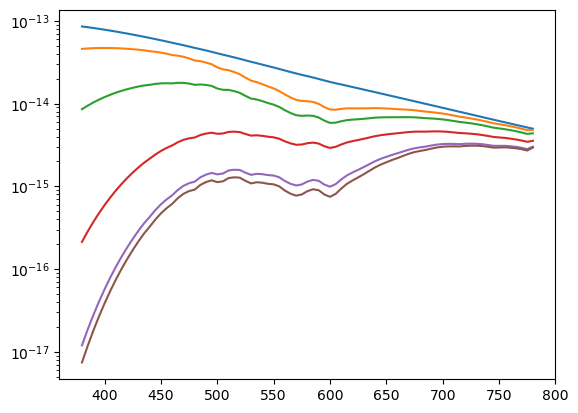

In [88]:
specs = []

for i in range(len(a)):
    spec = blackbody_norm * np.exp(-(a[i]*1000**4)/lam**4) * np.exp(-NO3[i]*sigma_o3) / lam**4
    plt.plot(lam,spec)
    specs.append(spec/max(spec))

plt.yscale('log')

[0.34775224 0.49064226 1.        ]
[0.24752717 0.40491694 1.        ]
[0.42651229 0.63348013 1.        ]
[0.96910085 1.         0.63530988]
[1.         0.84421148 0.38361289]
[1.         0.82796233 0.37864607]


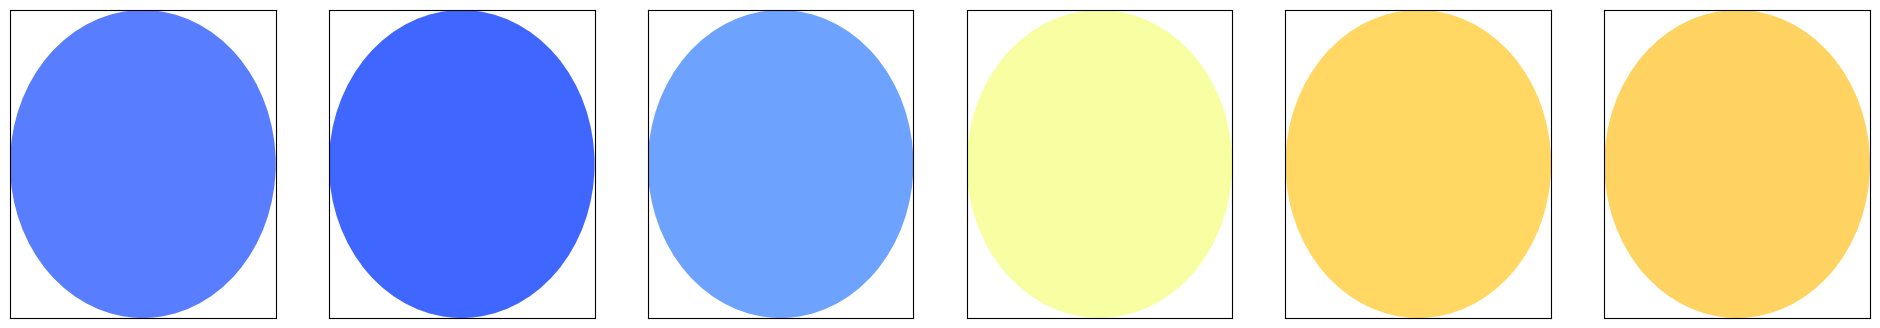

In [85]:
fig,ax = plt.subplots(1,6,figsize=(24,4))

for i in range(len(specs)):
    
    html_rgb = cs.spec_to_rgb(specs[i])
    print(html_rgb)
    circle = Circle(xy=(0,0), radius=1, fc=html_rgb)
    
    ax[i].set_xlim(-1,1)
    ax[i].set_ylim(-1,1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    ax[i].add_patch(circle)